<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/processdynamicsimul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
%%capture
! apt update -q
! apt-get install -q openjdk-25-jdk-headless -q
!pip install neqsim

In [44]:
%%capture
!pip install wget
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/examplefile.txt

# Combining a large provess simulation with dynamic process simulation with part of the process



# Combining a large process simulation with dynamic process simulation of a part of the process

This notebook demonstrates how to combine a large-scale process simulation with a dynamic simulation focusing on a specific part of the process.

# 1 Establish a steady state process model

In [45]:
from neqsim import jneqsim as neqsim

In [46]:
wellfluid = neqsim.thermo.system.SystemPrEos()
wellfluid.getCharacterization().setTBPModel("Two")
wellfluid.addComponent("CO2", 1.5870)
wellfluid.addComponent("methane", 52.51)
wellfluid.addComponent("ethane", 6.24)
wellfluid.addComponent("propane", 4.23)
wellfluid.addComponent("i-butane", 0.855)
wellfluid.addComponent("n-butane", 2.213)
wellfluid.addComponent("i-pentane", 1.124)
wellfluid.addComponent("n-pentane", 1.271)
wellfluid.addComponent("n-hexane", 2.289)
wellfluid.addTBPfraction("C7+_cut1", 0.8501, 108.47 / 1000.0, 0.7411)
wellfluid.addTBPfraction("C7+_cut2", 1.2802, 120.4 / 1000.0, 0.755)
wellfluid.addTBPfraction("C7+_cut3", 1.6603, 133.64 / 1000.0, 0.7695)
wellfluid.addTBPfraction("C7+_cut4", 6.5311, 164.70 / 1000.0, 0.799)
wellfluid.addTBPfraction("C7+_cut5", 6.3311, 215.94 / 1000.0, 0.8387)
wellfluid.addTBPfraction("C7+_cut6", 4.9618, 273.34 / 1000.0, 0.8754)
wellfluid.addTBPfraction("C7+_cut7", 2.9105, 334.92 / 1000.0, 0.90731)
wellfluid.addTBPfraction("C7+_cut8", 3.0505, 412.79 / 1000.0, 0.94575)
wellfluid.setMixingRule("classic")

In [47]:
from neqsim.thermo.thermoTools import readEclipseFluid, printFrame, TPflash
wellfluid_eclipse = readEclipseFluid('examplefile.txt')
wellfluid_eclipse.setMultiPhaseCheck(True)
#TPflash(wellfluid_eclipse)
#printFrame (wellfluid_eclipse)

# Establish the process model using NeqSim
In this notebook we will use the pydantic framework for implementing the model. This framework is well suited for implementing the model as an API, enables checking of validity of input parameters, API documentation, and  enables fast implementation of the model in a cloud framework (eg. used for running live process simulation or use in process digital twins).

The process flow diagram is presented in:

Andreasen, A. Applied Process Simulation-Driven Oil and Gas Separation Plant Optimization Using Surrogate Modeling and Evolutionary Algorithms. ChemEngineering 2020, 4, 11. https://doi.org/10.3390/chemengineering4010011


In [48]:
import json
from typing import Optional, List

import pandas as pd
from pydantic.dataclasses import dataclass
from pydantic import Field, field_validator

# Import or reference the neqsim library
# import neqsim  # Uncomment this if needed, depending on your environment.

@dataclass
class ProcessInput:
    """
    A data class to define input parameters for an oil and gas process simulation
    using the NEQSim process modeling library.

    This class uses Pydantic to structure and validate the input parameters
    required for running the simulation. It ensures that the input data is of
    the correct type and within acceptable ranges.

    Attributes:
        feed_rate (float): Molar flow rate [kgmole/hr].
        molar_composition (List[float]): Molar composition of well fluid [mole fraction].
            Must contain exactly 17 components.
        Psep1 (float): Pressure of first stage separator [barg].
        Tsep1 (float): Temperature of first stage separator [°C].
        Psep2 (float): Pressure of second stage separator [barg].
        Tsep2 (float): Temperature of second stage separator [°C].
        Psep3 (float): Pressure of third stage separator [barg].
        Tsep3 (float): Temperature of third stage separator [°C].
        Tscrub1 (float): Temperature of first stage recompressor scrubber [°C].
        Tscrub2 (float): Temperature of second stage recompressor scrubber [°C].
        Tscrub3 (float): Temperature of third stage recompressor scrubber [°C].
        Tscrub4 (float): Temperature of fourth stage recompressor scrubber [°C].
        Pcomp1 (float): Pressure after 1st stage export compressor [barg].
        Trefig (float): Temperature after cooling export gas [°C].
        P_oil_export (float): Pressure after oil export pump [barg].
        T_oil_export (float): Temperature of export oil [°C].
        P_gas_export (float): Pressure of export gas [barg].
        T_gas_export (float): Temperature of export gas [°C].
        dP_20_HA_01 (float): Pressure drop over heater 20-HA-01 [bar].
        dP_20_HA_02 (float): Pressure drop over heater 20-HA-02 [bar].
        dP_20_HA_03 (float): Pressure drop over heater 20-HA-03 [bar].
        dP_21_HA_01 (float): Pressure drop over heater 21-HA-01 [bar].
        dP_23_HA_01 (float): Pressure drop over heater 23-HA-01 [bar].
        dP_23_HA_02 (float): Pressure drop over heater 23-HA-02 [bar].
        dP_23_HA_03 (float): Pressure drop over heater 23-HA-03 [bar].
        dP_24_HA_01 (float): Pressure drop over heater 24-HA-01 [bar].
        dP_25_HA_01 (float): Pressure drop over heater 25-HA-01 [bar].
        dP_25_HA_02 (float): Pressure drop over heater 25-HA-02 [bar].
        dP_27_HA_01 (float): Pressure drop over heater 27-HA-01 [bar].
    """

    feed_rate: float = Field(title="molar flow rate [kgmole/hr]")
    molar_composition: List[float] = Field(title="molar composition of well fluid [molefraction]")
    Psep1: float = Field(ge=0.0, le=100.0, title="Pressure of first stage separator [barg]")
    Tsep1: float = Field(ge=0.0, le=100.0, title="Temperature of first stage separator [C]")
    Psep2: float = Field(ge=0.0, le=100.0, title="Pressure of second stage separator [barg]")
    Tsep2: float = Field(ge=0.0, le=100.0, title="Temperature of second stage separator [C]")
    Psep3: float = Field(ge=0.0, le=100.0, title="Pressure of third stage separator [barg]")
    Tsep3: float = Field(ge=0.0, le=100.0, title="Temperature of third stage separator [C]")
    Tscrub1: float = Field(ge=0.0, le=100.0, title="Temperature of first stage recompressor scrubber [C]")
    Tscrub2: float = Field(ge=0.0, le=100.0, title="Temperature of second stage recompressor scrubber [C]")
    Tscrub3: float = Field(ge=0.0, le=100.0, title="Temperature of third stage recompressor scrubber [C]")
    Tscrub4: float = Field(ge=0.0, le=100.0, title="Temperature of fourth stage recompressor scrubber [C]")
    Pcomp1: float = Field(ge=0.0, le=100.0, title="Pressure after 1st stage export compressor [barg]")
    Trefig: float = Field(ge=0.0, le=100.0, title="Temperature after cooling export gas [C]")
    P_oil_export: float = Field(ge=0.0, le=200.0, title="Pressure after oil export pump [barg]")
    T_oil_export: float = Field(ge=0.0, le=100.0, title="Temperature of export oil [C]")
    P_gas_export: float = Field(ge=0.0, le=300.0, title="Pressure of export gas [barg]")
    T_gas_export: float = Field(ge=0.0, le=100.0, title="Temperature of export gas [C]")
    dP_20_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 20-HA-01 [bar]")
    dP_20_HA_02: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 20-HA-02 [bar]")
    dP_20_HA_03: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 20-HA-03 [bar]")
    dP_21_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 21-HA-01 [bar]")
    dP_23_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 23-HA-01 [bar]")
    dP_23_HA_02: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 23-HA-02 [bar]")
    dP_23_HA_03: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 23-HA-03 [bar]")
    dP_24_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 24-HA-01 [bar]")
    dP_25_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 25-HA-01 [bar]")
    dP_25_HA_02: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 25-HA-02 [bar]")
    dP_27_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 27-HA-01 [bar]")

    @field_validator("molar_composition")
    def check_mole_rates(cls, v):
        """
        Validates that the molar composition list has exactly 17 components.
        """
        if len(v) != 17:
            raise ValueError("Molar composition should have 17 components.")
        return v


@dataclass
class ProcessOutput:
    """
    A data class to define output results from an oil and gas process simulation.

    Attributes:
        mass_balance (Optional[float]): The mass balance result (percentage).
        results (Optional[dict]): A dictionary containing simulation results
            retrieved from the NEQSim process model JSON report.
    """
    mass_balance: Optional[float] = None
    results: Optional[dict] = None


def getprocess():
    """
    Create and return a NEQSim oil process object using default or
    dummy fluid/stream components. This function demonstrates the
    general structure of a multi-stage oil and gas separation process
    with scrubbing, compressing, cooling, and pumping steps.

    Returns:
        A NEQSim ProcessSystem object representing the oil and gas
        separation process.
    """
    # NOTE:
    #   The following code presupposes that `wellfluid` and `neqsim.process`
    #   are available in your environment. If they are not, you will need
    #   to provide them or modify references accordingly.
    #   The lines below are placeholders for demonstration.

    # Create a reference fluid (ensure 'wellfluid' is defined or created externally)
    wellstream = neqsim.process.equipment.stream.Stream("well stream", wellfluid)
    wellstream.setTemperature(60.0, 'C')
    wellstream.setPressure(33.01, 'bara')

    # Heater
    well_stream_cooler = neqsim.process.equipment.heatexchanger.Heater("20-HA-01", wellstream)

    # First-stage separator
    first_stage_separator = neqsim.process.equipment.separator.ThreePhaseSeparator(
        "20-VA-01", well_stream_cooler.getOutStream()
    )

    # Throttling valve from first-stage separator oil out
    oilvalve1 = neqsim.process.equipment.valve.ThrottlingValve(
        "VLV-100", first_stage_separator.getOilOutStream()
    )

    # Mixer for second-stage inlet
    oil_2nd_stage_mixer = neqsim.process.equipment.mixer.Mixer("MIX-101")
    oil_2nd_stage_mixer.addStream(oilvalve1.getOutStream())

    # Heater
    oilHeaterFromFirstStage = neqsim.process.equipment.heatexchanger.Heater(
        "20-HA-02", oil_2nd_stage_mixer.getOutStream()
    )

    # Second-stage separator
    seccond_stage_separator = neqsim.process.equipment.separator.ThreePhaseSeparator(
        "20-VA-02", oilHeaterFromFirstStage.getOutStream()
    )

    # Throttling valve from second-stage separator oil out
    oilvalve2 = neqsim.process.equipment.valve.ThrottlingValve(
        "VLV-102", seccond_stage_separator.getOilOutStream()
    )

    # Reflux from well stream (for demonstration, setFlowRate is trivial)
    oilreflux = wellstream.clone()
    oilreflux.setName("third stage reflux")
    oilreflux.setFlowRate(1e-6, 'kg/hr')

    # Mixer for third-stage inlet
    thirdstageoilmixer = neqsim.process.equipment.mixer.Mixer("MIX-102")
    thirdstageoilmixer.addStream(oilvalve2.getOutStream())
    thirdstageoilmixer.addStream(oilreflux)

    # Heater
    oilHeaterFromSeccondStage = neqsim.process.equipment.heatexchanger.Heater(
        "20-HA-03", thirdstageoilmixer.getOutletStream()
    )

    # Third-stage separator
    third_stage_separator = neqsim.process.equipment.separator.ThreePhaseSeparator(
        "20-VA-03", oilHeaterFromSeccondStage.getOutStream()
    )

    # Cooler
    firstStageCooler = neqsim.process.equipment.heatexchanger.Cooler(
        "23-HA-03", third_stage_separator.getGasOutStream()
    )

    # Scrubber
    firstStageScrubber = neqsim.process.equipment.separator.Separator(
        "23-VG-03", firstStageCooler.getOutStream()
    )

    # Pump
    firststagescrubberpump = neqsim.process.equipment.pump.Pump(
        "23-PA-01", firstStageScrubber.getLiquidOutStream()
    )

    # Recycle
    lp_resycle = neqsim.process.equipment.util.Recycle("LP oil resycle")
    lp_resycle.addStream(firststagescrubberpump.getOutStream())
    lp_resycle.setOutletStream(oilreflux)
    lp_resycle.setTolerance(1e-6)

    # First-stage recompressor
    first_stage_recompressor = neqsim.process.equipment.compressor.Compressor(
        "23-KA-03", firstStageScrubber.getGasOutStream()
    )
    first_stage_recompressor.setIsentropicEfficiency(0.75)

    # Mixer combining first-stage recompressor gas and second-stage separator gas
    firststagegasmixer = neqsim.process.equipment.mixer.Mixer("MIX-103")
    firststagegasmixer.addStream(first_stage_recompressor.getOutStream())
    firststagegasmixer.addStream(seccond_stage_separator.getGasOutStream())

    # Second-stage cooler
    seccond_stage_cooler = neqsim.process.equipment.heatexchanger.Cooler(
        "23-HA-02", firststagegasmixer.getOutStream()
    )

    # Second-stage scrubber
    seccond_stage_scrubber = neqsim.process.equipment.separator.Separator(
        "23-VG-02", seccond_stage_cooler.getOutStream()
    )

    # Add second-stage scrubber liquid to third-stage oil mixer
    thirdstageoilmixer.addStream(seccond_stage_scrubber.getLiquidOutStream())

    # Second-stage recompressor
    seccond_stage_recompressor = neqsim.process.equipment.compressor.Compressor(
        "23-KA-02", seccond_stage_scrubber.getGasOutStream()
    )
    seccond_stage_recompressor.setIsentropicEfficiency(0.75)

    # Mixer combining second-stage recompressor gas and first-stage separator gas
    exportgasmixer = neqsim.process.equipment.mixer.Mixer("MIX-100")
    exportgasmixer.addStream(seccond_stage_recompressor.getOutStream())
    exportgasmixer.addStream(first_stage_separator.getGasOutStream())

    # Dew point cooler
    dew_point_cooler = neqsim.process.equipment.heatexchanger.Cooler(
        "23-HA-01", exportgasmixer.getOutStream()
    )

    # Dew point scrubber
    dew_point_scrubber = neqsim.process.equipment.separator.Separator(
        "23-VG-01", dew_point_cooler.getOutStream()
    )

    # Add dew point scrubber liquid to second-stage mixer
    oil_2nd_stage_mixer.addStream(dew_point_scrubber.getLiquidOutStream())

    # First stage export compressor
    first_stage_export_compressor = neqsim.process.equipment.compressor.Compressor(
        "23-KA-01", dew_point_scrubber.getGasOutStream()
    )
    first_stage_export_compressor.setIsentropicEfficiency(0.75)

    # Cooler after first stage export compressor
    dew_point_cooler2 = neqsim.process.equipment.heatexchanger.Cooler(
        "24-HA-01", first_stage_export_compressor.getOutStream()
    )

    # Scrubber after second dew point cooler
    dew_point_scrubber2 = neqsim.process.equipment.separator.Separator(
        "24-VG-01", dew_point_cooler2.getOutStream()
    )

    # Add the liquid to second-stage mixer
    oil_2nd_stage_mixer.addStream(dew_point_scrubber2.getLiquidOutStream())

    # Gas splitter
    gas_splitter = neqsim.process.equipment.splitter.Splitter(
        'splitter', dew_point_scrubber2.getGasOutStream()
    )
    gas_splitter.setSplitNumber(2)
    gas_splitter.setFlowRates([-1, 2966.0], "kg/hr")  # Example usage

    # Fuel gas stream
    fuel_gas = gas_splitter.getSplitStream(1)
    fuel_gas.setName('fuel gas')

    # Heat exchanger
    gas_heatexchanger = neqsim.process.equipment.heatexchanger.HeatExchanger(
        "25-HA-01", gas_splitter.getSplitStream(0)
    )
    gas_heatexchanger.setGuessOutTemperature(273.15 + 15.0)
    gas_heatexchanger.setUAvalue(800e3)

    # Dew point cooler #3
    dew_point_cooler3 = neqsim.process.equipment.heatexchanger.Cooler(
        "25-HA-02", gas_heatexchanger.getOutStream(0)
    )

    # Dew point scrubber #3
    dew_point_scrubber3 = neqsim.process.equipment.separator.Separator(
        "25-VG-01", dew_point_cooler3.getOutStream()
    )

    # Add dew point scrubber #3 liquid to the export gas mixer
    exportgasmixer.addStream(dew_point_scrubber3.getLiquidOutStream())

    # Set feed for the heat exchanger
    gas_heatexchanger.setFeedStream(1, dew_point_scrubber3.getGasOutStream())

    # Second-stage export compressor
    seccond_stage_export_compressor = neqsim.process.equipment.compressor.Compressor(
        "27-KA-01", gas_heatexchanger.getOutStream(1)
    )
    seccond_stage_export_compressor.setIsentropicEfficiency(0.75)

    # Cooler after second-stage export compressor
    export_compressor_cooler = neqsim.process.equipment.heatexchanger.Cooler(
        "27-HA-01", seccond_stage_export_compressor.getOutStream()
    )

    # Final export gas
    export_gas = export_compressor_cooler.getOutStream()
    export_gas.setName('export gas')

    # Export oil cooler
    export_oil_cooler = neqsim.process.equipment.heatexchanger.Cooler(
        "21-HA-01", third_stage_separator.getOilOutStream()
    )

    # Export oil pump
    export_oil_pump = neqsim.process.equipment.pump.Pump(
        "21-PA-01", export_oil_cooler.getOutStream()
    )
    export_oil = export_oil_pump.getOutStream()
    export_oil.setName('export oil')

    # Create a process system
    oilprocess = neqsim.process.processmodel.ProcessSystem()
    oilprocess.add(wellstream)
    oilprocess.add(well_stream_cooler)
    oilprocess.add(first_stage_separator)
    oilprocess.add(oilvalve1)
    oilprocess.add(oil_2nd_stage_mixer)
    oilprocess.add(oilHeaterFromFirstStage)
    oilprocess.add(seccond_stage_separator)
    oilprocess.add(oilvalve2)
    oilprocess.add(oilreflux)
    oilprocess.add(thirdstageoilmixer)
    oilprocess.add(oilHeaterFromSeccondStage)
    oilprocess.add(third_stage_separator)
    oilprocess.add(firstStageCooler)
    oilprocess.add(firstStageScrubber)
    oilprocess.add(firststagescrubberpump)
    oilprocess.add(lp_resycle)
    oilprocess.add(first_stage_recompressor)
    oilprocess.add(firststagegasmixer)
    oilprocess.add(seccond_stage_cooler)
    oilprocess.add(seccond_stage_scrubber)
    oilprocess.add(seccond_stage_recompressor)
    oilprocess.add(exportgasmixer)
    oilprocess.add(dew_point_cooler)
    oilprocess.add(dew_point_scrubber)
    oilprocess.add(first_stage_export_compressor)
    oilprocess.add(dew_point_cooler2)
    oilprocess.add(dew_point_scrubber2)
    oilprocess.add(gas_splitter)
    oilprocess.add(gas_heatexchanger)
    oilprocess.add(dew_point_cooler3)
    oilprocess.add(dew_point_scrubber3)
    oilprocess.add(seccond_stage_export_compressor)
    oilprocess.add(export_compressor_cooler)
    oilprocess.add(export_oil_cooler)
    oilprocess.add(export_oil_pump)
    oilprocess.add(export_gas)
    oilprocess.add(export_oil)
    oilprocess.add(fuel_gas)

    return oilprocess


def updateinput(process, locinput):
    """
    Update the NEQSim process model with the provided input parameters.

    Attempts to set or update the operating conditions for each unit
    in the process. If a unit does not exist or is not named as expected,
    an AttributeError is caught and printed.

    Args:
        process: A NEQSim ProcessSystem object.
        locinput (ProcessInput): A validated ProcessInput object
            containing simulation parameters.
    """
    try:
        # Well stream
        process.getUnit('well stream').setFlowRate(locinput.feed_rate * 1e3 / 3600, 'mol/sec')
        process.getUnit('well stream').getFluid().setMolarComposition(locinput.molar_composition)
        process.getUnit('well stream').setPressure(locinput.Psep1 + locinput.dP_20_HA_01, "barg")
        process.getUnit('well stream').setTemperature(60.0, "C")

        # 20-HA-01
        process.getUnit('20-HA-01').setOutTemperature(locinput.Tsep1, "C")
        process.getUnit('20-HA-01').setOutPressure(locinput.Psep1, "barg")

        # VLV-100
        process.getUnit('VLV-100').setOutletPressure(locinput.Psep2 + locinput.dP_20_HA_02, 'barg')

        # 20-HA-02
        process.getUnit('20-HA-02').setOutTemperature(locinput.Tsep2, 'C')
        process.getUnit('20-HA-02').setOutPressure(locinput.Psep2, 'barg')

        # VLV-102
        process.getUnit('VLV-102').setOutletPressure(locinput.Psep3 + locinput.dP_20_HA_03, 'barg')

        # 20-HA-03
        process.getUnit('20-HA-03').setOutTemperature(locinput.Tsep3, 'C')
        process.getUnit('20-HA-03').setOutPressure(locinput.Psep3, 'barg')

        # 23-HA-03
        process.getUnit('23-HA-03').setOutTemperature(locinput.Tscrub1, 'C')
        process.getUnit('23-HA-03').setOutPressure(locinput.Psep3 - locinput.dP_20_HA_03, 'barg')

        # 23-PA-01
        process.getUnit('23-PA-01').setPressure(locinput.Psep3 + locinput.dP_20_HA_03, 'barg')

        # 23-KA-03
        process.getUnit('23-KA-03').setOutletPressure(locinput.Psep2, 'barg')

        # 23-HA-02
        process.getUnit('23-HA-02').setOutTemperature(locinput.Tscrub2, 'C')
        process.getUnit('23-HA-02').setOutPressure(locinput.Psep2 - locinput.dP_23_HA_02, 'barg')

        # 23-KA-02
        process.getUnit('23-KA-02').setOutletPressure(locinput.Psep1, 'barg')

        # 23-KA-01
        process.getUnit('23-KA-01').setOutletPressure(locinput.Pcomp1, 'barg')

        # 23-HA-01
        process.getUnit('23-HA-01').setOutTemperature(locinput.Tscrub3, 'C')
        process.getUnit('23-HA-01').setOutPressure(locinput.Psep1 - locinput.dP_23_HA_01, 'barg')

        # 24-HA-01
        process.getUnit('24-HA-01').setOutTemperature(locinput.Tscrub4, 'C')
        process.getUnit('24-HA-01').setOutPressure(locinput.Pcomp1 - locinput.dP_24_HA_01, 'barg')

        # 27-KA-01
        process.getUnit('27-KA-01').setOutletPressure(locinput.P_gas_export, 'barg')

        # 25-HA-02
        process.getUnit('25-HA-02').setOutTemperature(locinput.Trefig, 'C')
        process.getUnit('25-HA-02').setOutPressure(
            locinput.Pcomp1 - locinput.dP_25_HA_01 - locinput.dP_20_HA_02, 'barg'
        )

        # 21-HA-01
        process.getUnit('21-HA-01').setOutTemperature(locinput.T_oil_export, 'C')
        process.getUnit('21-HA-01').setOutPressure(
            locinput.Psep3 - locinput.dP_21_HA_01, 'barg'
        )

        # 21-PA-01
        process.getUnit('21-PA-01').setOutletPressure(locinput.P_oil_export + 1.01325)

        # 27-HA-01
        process.getUnit('27-HA-01').setOutTemperature(40.0, 'C')
        process.getUnit('27-HA-01').setOutletPressure(locinput.P_oil_export - locinput.dP_27_HA_01)

    except AttributeError as e:
        print(f"Failed to update unit parameters: {e}")


def getoutput(process):
    """
    Retrieve simulation results from the NEQSim process model.

    Generates a JSON report using NEQSim's built-in reporting functions,
    then calculates a simple mass balance based on the feed, fuel gas,
    export gas, and exported oil streams.

    Args:
        process: A NEQSim ProcessSystem object.

    Returns:
        dict: A dictionary containing:
            - 'results': The JSON-parsed NEQSim report.
            - 'mass_balance': The mass balance calculation (as a percentage).
    """
    # Generate a JSON report from the NEQSim process
    json_report = str(neqsim.process.util.report.Report(process).generateJsonReport())

    # Calculate a simple mass balance
    feed_flow = process.getUnit('well stream').getFlowRate('kg/hr')
    fuel_flow = process.getUnit('fuel gas').getFlowRate('kg/hr')
    export_gas_flow = process.getUnit('27-KA-01').getOutStream().getFlowRate('kg/hr')
    export_oil_flow = process.getUnit('20-VA-03').getOilOutStream().getFlowRate('kg/hr')

    mass_balance_calc = (feed_flow - fuel_flow - export_gas_flow - export_oil_flow) / feed_flow * 100

    return {
        'results': json.loads(json_report),
        'mass_balance': mass_balance_calc
    }


def run_simulation(process, input_params, timeout=60):
    """
    Run the oil process simulation with a specified timeout.

    - The input parameters are validated and applied to the process model.
    - The simulation is run in a separate thread, with a default timeout of 60 seconds.
    - If the thread times out, an interruption is triggered, and `None` is returned.

    Args:
        process: A NEQSim ProcessSystem object to run the simulation on.
        input_params (dict): A dictionary of parameters to initialize
            the ProcessInput data class.
        timeout (int, optional): Timeout in seconds. Defaults to 60.

    Returns:
        ProcessOutput or None:
            If the simulation completes successfully, returns a ProcessOutput
            object containing the simulation results. Otherwise, returns None.
    """
    # Validate and update process inputs
    updateinput(process=process, locinput=ProcessInput(**input_params))

    # Run the process in a separate thread
    thread = process.runAsThread()
    thread.join(timeout * 1000)  # Timeout in milliseconds

    # Check if the thread is still alive after the timeout and interupt/stop if alive
    if thread.isAlive():
        thread.interrupt()
        thread.join()
        print("Process calculation timed out. Consider recreating the process object or adjusting parameters.")
        return None

    # On successful completion, retrieve results and wrap in a ProcessOutput
    return ProcessOutput(**getoutput(process=process))


In [49]:
process1 = getprocess()

In [50]:
inputparam = {
 'feed_rate': 8000.0,
 'molar_composition': list(wellfluid.getMolarComposition()),
 'Tsep1': 70.0,
 'Psep1': 31.5,
 'Psep2': 8.0,
 'Psep3': 1.5,
 'Tsep2': 68.2,
 'Tsep3': 65.0,
 'Tscrub1': 32.0,
 'Tscrub2': 32.0,
 'Tscrub3': 32.0,
 'Tscrub4': 30.0,
 'Pcomp1': 90.0,
 'Trefig': 10.0,
 'P_oil_export':60.0,
 'T_oil_export':48.5,
 'P_gas_export': 188.6,
 'T_gas_export': 40.0,
 'dP_20_HA_01':	0.5,
 'dP_20_HA_02':	0.5,
 'dP_20_HA_03':	0.5,
 'dP_21_HA_01':	0.5,
 'dP_23_HA_01':	0.3,
 'dP_23_HA_02':	1.0,
 'dP_23_HA_03':	1.0,
 'dP_24_HA_01':	1.0,
 'dP_25_HA_01':	0.5,
 'dP_25_HA_02':	0.5,
 'dP_27_HA_01':	0.0,
}

results = run_simulation(process=process1, input_params=inputparam)


In [51]:
results.results

{'LP oil resycle': {'data': {'outlet mass flow': {'value': '1.1132318459643475',
    'unit': 'kg/hr'},
   'error pressure': {'value': '0.0', 'unit': ''},
   'outlet pressure': {'value': '3.01325', 'unit': 'bara'},
   'error composition': {'value': '0.0', 'unit': ''},
   'outlet temperature': {'value': '32.018524723498786', 'unit': 'C'},
   'error flow': {'value': '0.0', 'unit': ''},
   'error temperature': {'value': '0.0', 'unit': ''}},
  'tagName': '',
  'name': 'LP oil resycle'},
 '20-HA-01': {'data': {'inlet temperature': {'value': '60.0', 'unit': 'C'},
   'outlet pressure': {'value': '33.01', 'unit': 'bara'},
   'mass flow': {'value': 'NaN', 'unit': 'kg/hr'},
   'duty': {'value': '0.0', 'unit': 'W'},
   'inlet pressure': {'value': '33.01325', 'unit': 'bara'},
   'outlet temperature': {'value': '60.0', 'unit': 'C'}},
  'tagName': '',
  'name': '20-HA-01'},
 '20-HA-02': {'data': {'inlet temperature': {'value': '58.77855188327999',
    'unit': 'C'},
   'outlet pressure': {'value': '9.

# Reading the part process for dynamic analysis
We will do a simple evaluation of closing the vlave of the outlet of the dew point scruber.

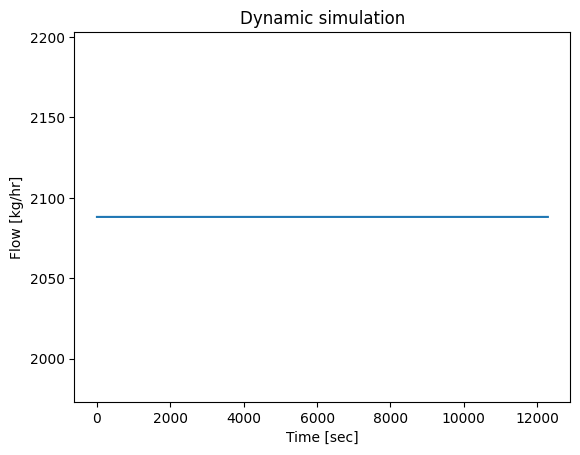

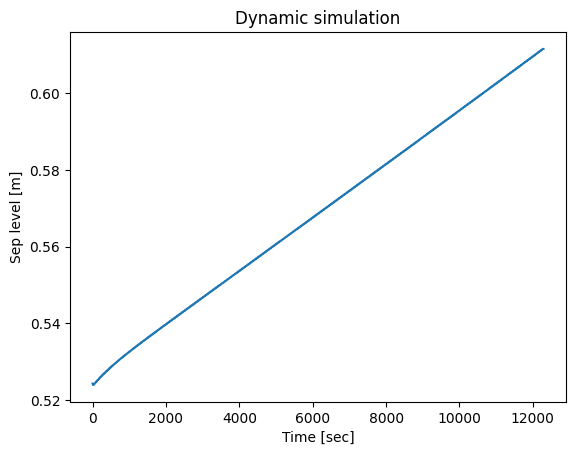

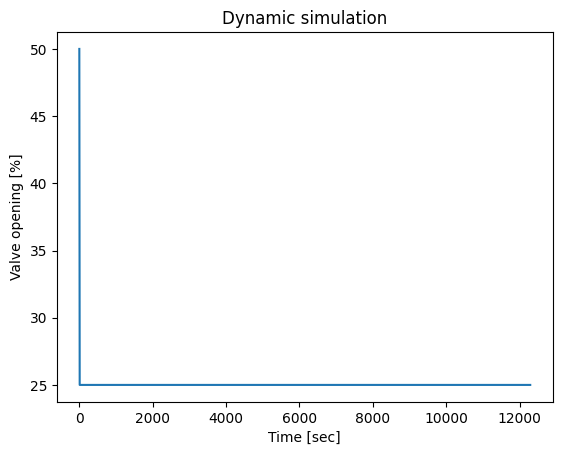

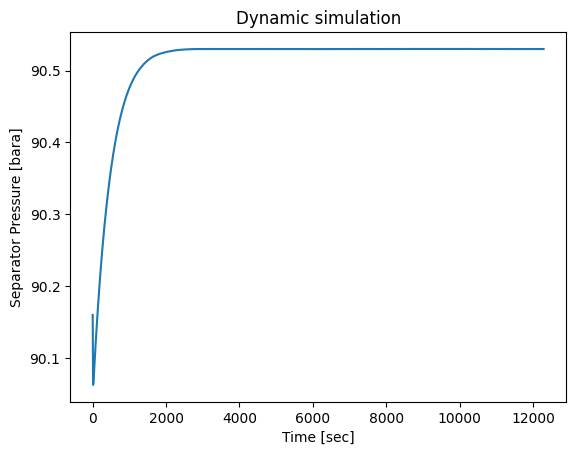

In [54]:
dynprocess = neqsim.process.processmodel.ProcessSystem()
dynprocess.add(process1.getUnit('25-VG-01'))
dynprocess.getUnit('25-VG-01').setCalculateSteadyState(False)
dynprocess.getUnit('25-VG-01').setSeparatorLength(3.0)
dynprocess.getUnit('25-VG-01').setInternalDiameter(1.0)

flowTransmitter = neqsim.process.measurementdevice.VolumeFlowTransmitter(process1.getUnit('25-VG-01').getFeedStream())
flowTransmitter.setUnit("kg/hr")
flowTransmitter.setMaximumValue(100.0)
flowTransmitter.setMinimumValue(10.0)

separatorLevelTransmitter = neqsim.process.measurementdevice.LevelTransmitter(dynprocess.getUnit('25-VG-01'));
separatorLevelTransmitter.setName("separatorLevelTransmitter1");
separatorLevelTransmitter.setMaximumValue(0.8);
separatorLevelTransmitter.setMinimumValue(3.0);

valve2 = neqsim.process.equipment.valve.ThrottlingValve("valve_2", dynprocess.getUnit('25-VG-01').getLiquidOutStream())
valve2.setOutletPressure(10.0)
valve2.setPercentValveOpening(50)
valve2.setCalculateSteadyState(False)
dynprocess.add(valve2)

valve3 = neqsim.process.equipment.valve.ThrottlingValve("valve_3", dynprocess.getUnit('25-VG-01').getGasOutStream())
valve3.setOutletPressure(10.0)
valve3.setPercentValveOpening(50)
valve3.setCalculateSteadyState(False)
dynprocess.add(valve3)

dynprocess.run()

time = []
valveopening = []
separator_pressure = []
sep_level = []
flow = []

dynprocess.setTimeStep(10);
for i in range(30):
  time.append(dynprocess.getTime())
  valveopening.append(valve2.getPercentValveOpening())
  flow.append(flowTransmitter.getMeasuredValue())
  separator_pressure.append(dynprocess.getUnit('25-VG-01').getGasOutStream().getPressure())
  sep_level.append(separatorLevelTransmitter.getMeasuredValue())
  dynprocess.runTransient()

  valve2.setPercentValveOpening(25)

  for i in range(40):
    time.append(dynprocess.getTime())
    valveopening.append(valve2.getPercentValveOpening())
    flow.append(flowTransmitter.getMeasuredValue())
    separator_pressure.append(dynprocess.getUnit('25-VG-01').getGasOutStream().getPressure())
    sep_level.append(separatorLevelTransmitter.getMeasuredValue())
    dynprocess.runTransient()

import matplotlib.pyplot as plt

plt.plot(time, flow)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Flow [kg/hr]")
plt.show()

plt.plot(time, sep_level)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Sep level [m]")
plt.show()

plt.plot(time, valveopening)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Valve opening [%]")
plt.show()

plt.plot(time, separator_pressure)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Separator Pressure [bara]")
plt.show()
